# 05a4 – E3SFCA Capacity Scenario Runner

This notebook applies the Enhanced 3-Step Floating Catchment Area (E3SFCA) method to evaluate CT access under baseline and expansion scenarios.

---

### Purpose

We compare population-level CT scanner accessibility under four capacity scenarios:

- **Baseline** (existing Acute + CDC sites)
- **+5% capacity** (4 new sites, 1 scanner each)
- **+10% capacity** (6 new sites, 2×2, 4×1 scanners)
- **+20% capacity** (8 new sites, 2 scanners each)

---

### Input Files

- LSOA population + demand (`gdf_lsoa_CT_accessibility_2024.gpkg`)
- LSOA-to-LSOA travel matrix (`LSOA_to_LSOA_complete.csv`)
- Site capacity files (baseline + uplift scenarios in `E3SFCA_Scenarios/`)
- NHS CT capability reference files (Acute, CDC)

---

### Outputs

- Accessibility scores (`Fi`) for each LSOA per scenario
- Supply-to-demand (`Rj`) for each site
- Visual 2×2 maps comparing scenario impacts
- Scenario outputs exported to GPKG and CSV


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import mapclassify
import warnings

warnings.filterwarnings("ignore")


In [2]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
lsoa_gpkg_path = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Reference site files (used for validation, not scenario runs)
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Scenario CT capacity files (with baseline sites already included)
scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")
scenario_files = {
    "Baseline": os.path.join(scenario_dir, "baseline_ct_sites.csv"),
    "+5%": os.path.join(scenario_dir, "scenario_5pct_plus_baseline.csv"),
    "+10%": os.path.join(scenario_dir, "scenario_10pct_plus_baseline.csv"),
    "+20%": os.path.join(scenario_dir, "scenario_20pct_plus_baseline.csv")
}

# Output directory
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)


In [3]:
# ----------------------------------------------------------
# Step 2 – Load Travel Matrix and LSOA Base Data
# ----------------------------------------------------------

# Load the full LSOA-to-LSOA travel matrix
df_travel = pd.read_csv(travel_matrix_path)

# Filter to car travel within 60 minutes
df_travel_car = df_travel[df_travel["travel_time_car"] <= 60].copy()
print("Travel matrix (≤60 min):", df_travel_car.shape)

# Load base LSOA GeoDataFrame with demand + geometry
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)
assert all(col in gdf_lsoa.columns for col in ["lsoa21cd", "ct_total_demand", "geometry"])
print("LSOA base shape:", gdf_lsoa.shape)

# Clean IDs for merge consistency
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()
df_travel_car["destination_name"] = df_travel_car["destination_name"].astype(str).str.strip()
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()


Travel matrix (≤60 min): (2199474, 5)
LSOA base shape: (3451, 51)


In [4]:
# ----------------------------------------------------------
# Step 3 – Load All Scenario Site Files
# ----------------------------------------------------------

scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")

scenario_files = {
    "Baseline": "baseline_ct_sites.csv",
    "+5%": "scenario_5pct_plus_baseline.csv",
    "+10%": "scenario_10pct_plus_baseline.csv",
    "+20%": "scenario_20pct_plus_baseline.csv"
}

scenario_site_data = {}

for label, fname in scenario_files.items():
    path = os.path.join(scenario_dir, fname)
    df_sites = pd.read_csv(path)
    
    # Basic checks
    assert all(col in df_sites.columns for col in ["Site Name", "lsoa21cd", "scanner_count"])
    df_sites = df_sites[df_sites["lsoa21cd"].notna()].copy()
    df_sites["lsoa21cd"] = df_sites["lsoa21cd"].astype(str).str.strip()
    
    scenario_site_data[label] = df_sites
    print(f"{label} – Loaded {len(df_sites)} site rows.")


Baseline – Loaded 36 site rows.
+5% – Loaded 40 site rows.
+10% – Loaded 42 site rows.
+20% – Loaded 44 site rows.


In [5]:
# ----------------------------------------------------------
# Step 4 – Filter Travel Matrix to Scenario-Specific CT Sites
# ----------------------------------------------------------

# Prepare travel matrix lookups per scenario
travel_matrices_by_scenario = {}

for label, df_sites in scenario_site_data.items():
    print(f"\nFiltering travel matrix for: {label}")
    
    # Extract valid CT LSOA destination codes
    ct_lsoa_codes = df_sites["lsoa21cd"].unique()
    
    # Filter original travel matrix to only those destinations
    df_filtered = df_travel_car[df_travel_car["destination_name"].isin(ct_lsoa_codes)].copy()
    
    print(f"{label} – Filtered travel matrix shape: {df_filtered.shape}")
    
    # Save for next step
    travel_matrices_by_scenario[label] = df_filtered



Filtering travel matrix for: Baseline
Baseline – Filtered travel matrix shape: (19496, 5)

Filtering travel matrix for: +5%
+5% – Filtered travel matrix shape: (20690, 5)

Filtering travel matrix for: +10%
+10% – Filtered travel matrix shape: (21081, 5)

Filtering travel matrix for: +20%
+20% – Filtered travel matrix shape: (22638, 5)


In [6]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay to Each Scenario
# ----------------------------------------------------------

# Define stepwise decay function (0–60 min range)
def apply_decay_weight(travel_time):
    if travel_time <= 10:
        return 1.0
    elif travel_time <= 20:
        return 0.75
    elif travel_time <= 30:
        return 0.5
    elif travel_time <= 40:
        return 0.3
    elif travel_time <= 50:
        return 0.15
    elif travel_time <= 60:
        return 0.05
    else:
        return 0.01  # Should not happen but included for robustness

# Apply decay weights across all filtered travel matrices
for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nApplying decay weights for: {label}")
    
    # Apply decay
    df_travel_scenario["decay_weight"] = df_travel_scenario["travel_time_car"].apply(apply_decay_weight)
    
    # Save updated DataFrame
    travel_matrices_by_scenario[label] = df_travel_scenario
    
    # Summary stats
    print("Decay weight distribution:")
    print(df_travel_scenario["decay_weight"].value_counts().sort_index())



Applying decay weights for: Baseline
Decay weight distribution:
decay_weight
0.05    6439
0.15    4894
0.30    2892
0.50    2365
0.75    1976
1.00     930
Name: count, dtype: int64

Applying decay weights for: +5%
Decay weight distribution:
decay_weight
0.05    6777
0.15    5407
0.30    3065
0.50    2478
0.75    2008
1.00     955
Name: count, dtype: int64

Applying decay weights for: +10%
Decay weight distribution:
decay_weight
0.05    6919
0.15    5490
0.30    3126
0.50    2526
0.75    2056
1.00     964
Name: count, dtype: int64

Applying decay weights for: +20%
Decay weight distribution:
decay_weight
0.05    7696
0.15    5782
0.30    3269
0.50    2701
0.75    2202
1.00     988
Name: count, dtype: int64


In [7]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios (Rj) per Scenario
# ----------------------------------------------------------

rj_lookup_by_scenario = {}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nCalculating Rj for: {label}")
    
    # 1) Get the corresponding site file
    df_sites = scenario_site_data[label].copy()
    
    # 2) Join ct_total_demand into travel matrix from gdf_lsoa
    df = df_travel_scenario.merge(
        gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
        how="left",
        left_on="origin_name",
        right_on="lsoa21cd"
    ).drop(columns=["lsoa21cd"])
    
    # 3) Remove rows with missing demand
    df = df.dropna(subset=["ct_total_demand"]).copy()
    
    # 4) Compute decay-weighted demand
    df["weighted_demand"] = df["ct_total_demand"] * df["decay_weight"]
    
    # 5) Sum weighted demand by destination
    demand_per_site = (
        df.groupby("destination_name")["weighted_demand"]
        .sum()
        .reset_index()
        .rename(columns={"weighted_demand": "total_weighted_demand"})
    )
    
    # 6) Merge with site scanner count
    supply_df = df_sites[["lsoa21cd", "scanner_count"]].rename(columns={"lsoa21cd": "destination_name"})
    rj_df = demand_per_site.merge(supply_df, on="destination_name", how="left")
    
    # 7) If any missing scanner counts, assume 1
    rj_df["scanner_count"] = rj_df["scanner_count"].fillna(1)
    
    # 8) Calculate Rj and Rj per 1000
    rj_df["Rj"] = rj_df["scanner_count"] / rj_df["total_weighted_demand"]
    rj_df["Rj_per_1000"] = rj_df["Rj"] * 1000
    
    # 9) Store in lookup
    rj_lookup_by_scenario[label] = rj_df
    
    # 10) Preview
    print(rj_df[["Rj", "Rj_per_1000"]].describe())



Calculating Rj for: Baseline
              Rj  Rj_per_1000
count  30.000000    30.000000
mean    0.000066     0.065591
std     0.000040     0.040220
min     0.000014     0.013513
25%     0.000032     0.032393
50%     0.000061     0.061242
75%     0.000084     0.083872
max     0.000159     0.159318

Calculating Rj for: +5%
              Rj  Rj_per_1000
count  34.000000    34.000000
mean    0.000209     0.209160
std     0.000614     0.614453
min     0.000014     0.013513
25%     0.000032     0.032393
50%     0.000061     0.061242
75%     0.000087     0.087085
max     0.003207     3.206982

Calculating Rj for: +10%
              Rj  Rj_per_1000
count  36.000000    36.000000
mean    0.000607     0.606550
std     0.001691     1.690827
min     0.000014     0.013513
25%     0.000035     0.034880
50%     0.000068     0.067673
75%     0.000097     0.096791
max     0.006799     6.799352

Calculating Rj for: +20%
              Rj  Rj_per_1000
count  38.000000    38.000000
mean    0.000508     0.

In [8]:
# ----------------------------------------------------------
# Step 7 – Compute Final E3SFCA Accessibility Score (Fi) per LSOA
# ----------------------------------------------------------

# Dictionary to store Fi scores per scenario
fi_scores_by_scenario = {}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nComputing Fi for: {label}")
    
    # 1) Get Rj values
    rj_df = rj_lookup_by_scenario[label][["destination_name", "Rj"]].copy()
    
    # 2) Merge Rj into travel matrix
    df = df_travel_scenario.merge(
        rj_df,
        how="left",
        on="destination_name"
    )
    
    # 3) Compute Fi partial: decay × Rj
    df["fi_component"] = df["decay_weight"] * df["Rj"]
    
    # 4) Sum Fi components by origin (LSOA)
    fi_df = (
        df.groupby("origin_name")["fi_component"]
        .sum()
        .reset_index()
        .rename(columns={"origin_name": "lsoa21cd", "fi_component": f"score_{label.lower().replace('+','plus').replace('%','pct')}"})
    )
    
    # 5) Store
    fi_scores_by_scenario[label] = fi_df
    
    # 6) Merge into gdf_lsoa (optional here – do later in Step 8 for plotting)
    print(fi_df.head(3))



Computing Fi for: Baseline
    lsoa21cd  score_baseline
0  E01014014        0.000058
1  E01014031        0.000020
2  E01014032        0.000033

Computing Fi for: +5%
    lsoa21cd  score_plus5pct
0  E01014014        0.000059
1  E01014031        0.000020
2  E01014032        0.000033

Computing Fi for: +10%
    lsoa21cd  score_plus10pct
0  E01014014         0.000059
1  E01014031         0.000020
2  E01014032         0.000033

Computing Fi for: +20%
    lsoa21cd  score_plus20pct
0  E01014014         0.000076
1  E01014031         0.000023
2  E01014032         0.000042


In [9]:
# ----------------------------------------------------------
# Step 7a – Merge E3SFCA Scores and Compare Scenario Performance
# ----------------------------------------------------------

# 1) Merge all Fi (score) columns into gdf_lsoa
for label, fi_df in fi_scores_by_scenario.items():
    score_col = fi_df.columns[-1]  # e.g. 'score_baseline'
    gdf_lsoa = gdf_lsoa.merge(fi_df, on="lsoa21cd", how="left")

# 2) Extract score column names
score_cols = [col for col in gdf_lsoa.columns if col.startswith("score_")]
print("\nMerged Fi score columns:", score_cols)

# 3) Compute differences from baseline for each uplift scenario
for label in ["+5%", "+10%", "+20%"]:
    col_base = "score_baseline"
    col_scenario = f"score_{label.lower().replace('+','plus').replace('%','pct')}"
    delta_col = f"delta_{label.lower().replace('+','plus').replace('%','pct')}"
    
    gdf_lsoa[delta_col] = gdf_lsoa[col_scenario] - gdf_lsoa[col_base]

# 4) Print summary stats for access gains
print("\n--- Access Score Delta Summary ---")
for col in gdf_lsoa.columns:
    if col.startswith("delta_"):
        print(f"{col:<22} | Mean: {gdf_lsoa[col].mean():.5f} | "
              f"Min: {gdf_lsoa[col].min():.5f} | "
              f"Max: {gdf_lsoa[col].max():.5f}")



Merged Fi score columns: ['score_baseline', 'score_plus5pct', 'score_plus10pct', 'score_plus20pct']

--- Access Score Delta Summary ---
delta_plus5pct         | Mean: 0.00000 | Min: 0.00000 | Max: 0.00187
delta_plus10pct        | Mean: 0.00000 | Min: 0.00000 | Max: 0.00187
delta_plus20pct        | Mean: 0.00002 | Min: 0.00000 | Max: 0.00373


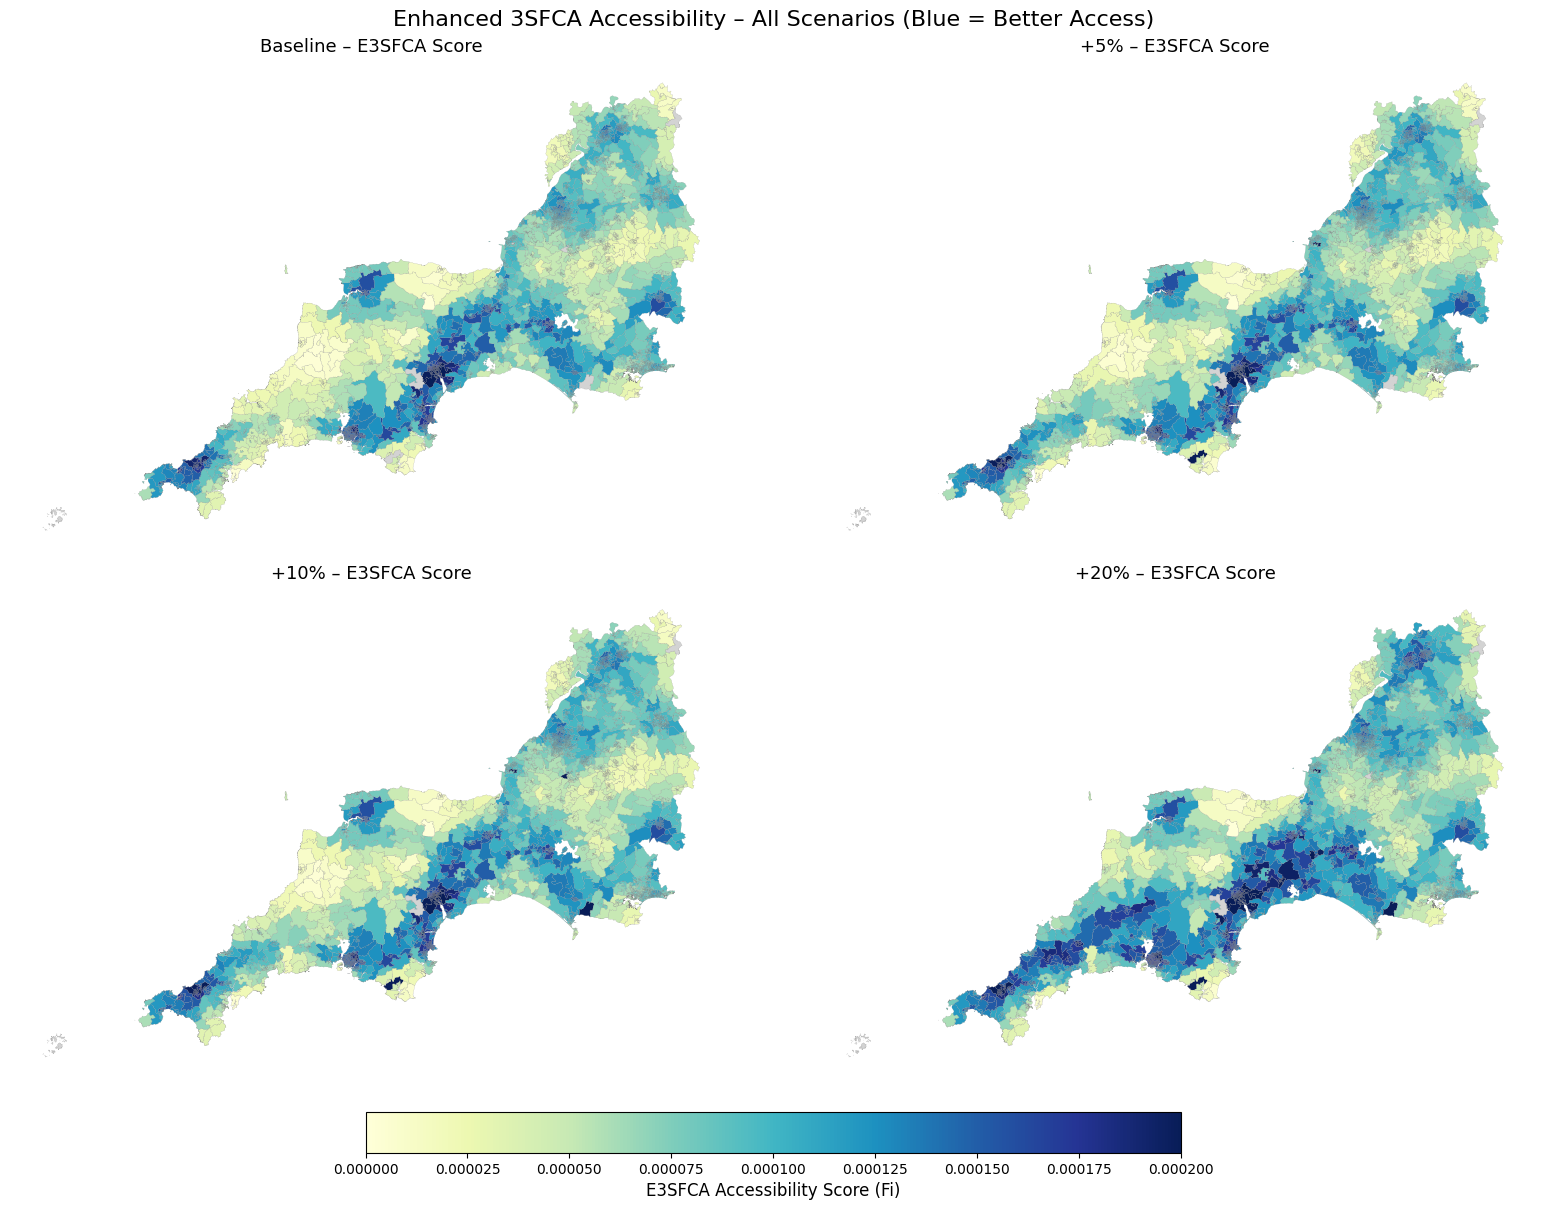

In [10]:
# ----------------------------------------------------------
# Step 8 – 2×2 Choropleth (Blue = Good, Green = Bad)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Mapping of scenario label to column name
scenarios_plot = {
    "Baseline": "score_baseline",
    "+5%": "score_plus5pct",
    "+10%": "score_plus10pct",
    "+20%": "score_plus20pct"
}

# Manual colour scale
vmin = 0.0000
vmax = 0.0002  # Adjust based on your data

# Blue = good, Green = bad (reversed colourmap)
cmap = "YlGnBu"

# Plot each subplot without separate colourbars
for ax, (label, col) in zip(axes.flat, scenarios_plot.items()):
    gdf_lsoa.plot(
        column=col,
        cmap=cmap,
        linewidth=0.1,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"}
    )
    ax.set_title(f"{label} – E3SFCA Score", fontsize=13)
    ax.axis("off")

# Shared horizontal colourbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("E3SFCA Accessibility Score (Fi)", fontsize=12)

# Overall title
fig.suptitle("Enhanced 3SFCA Accessibility – All Scenarios (Blue = Better Access)", fontsize=16)
plt.show()


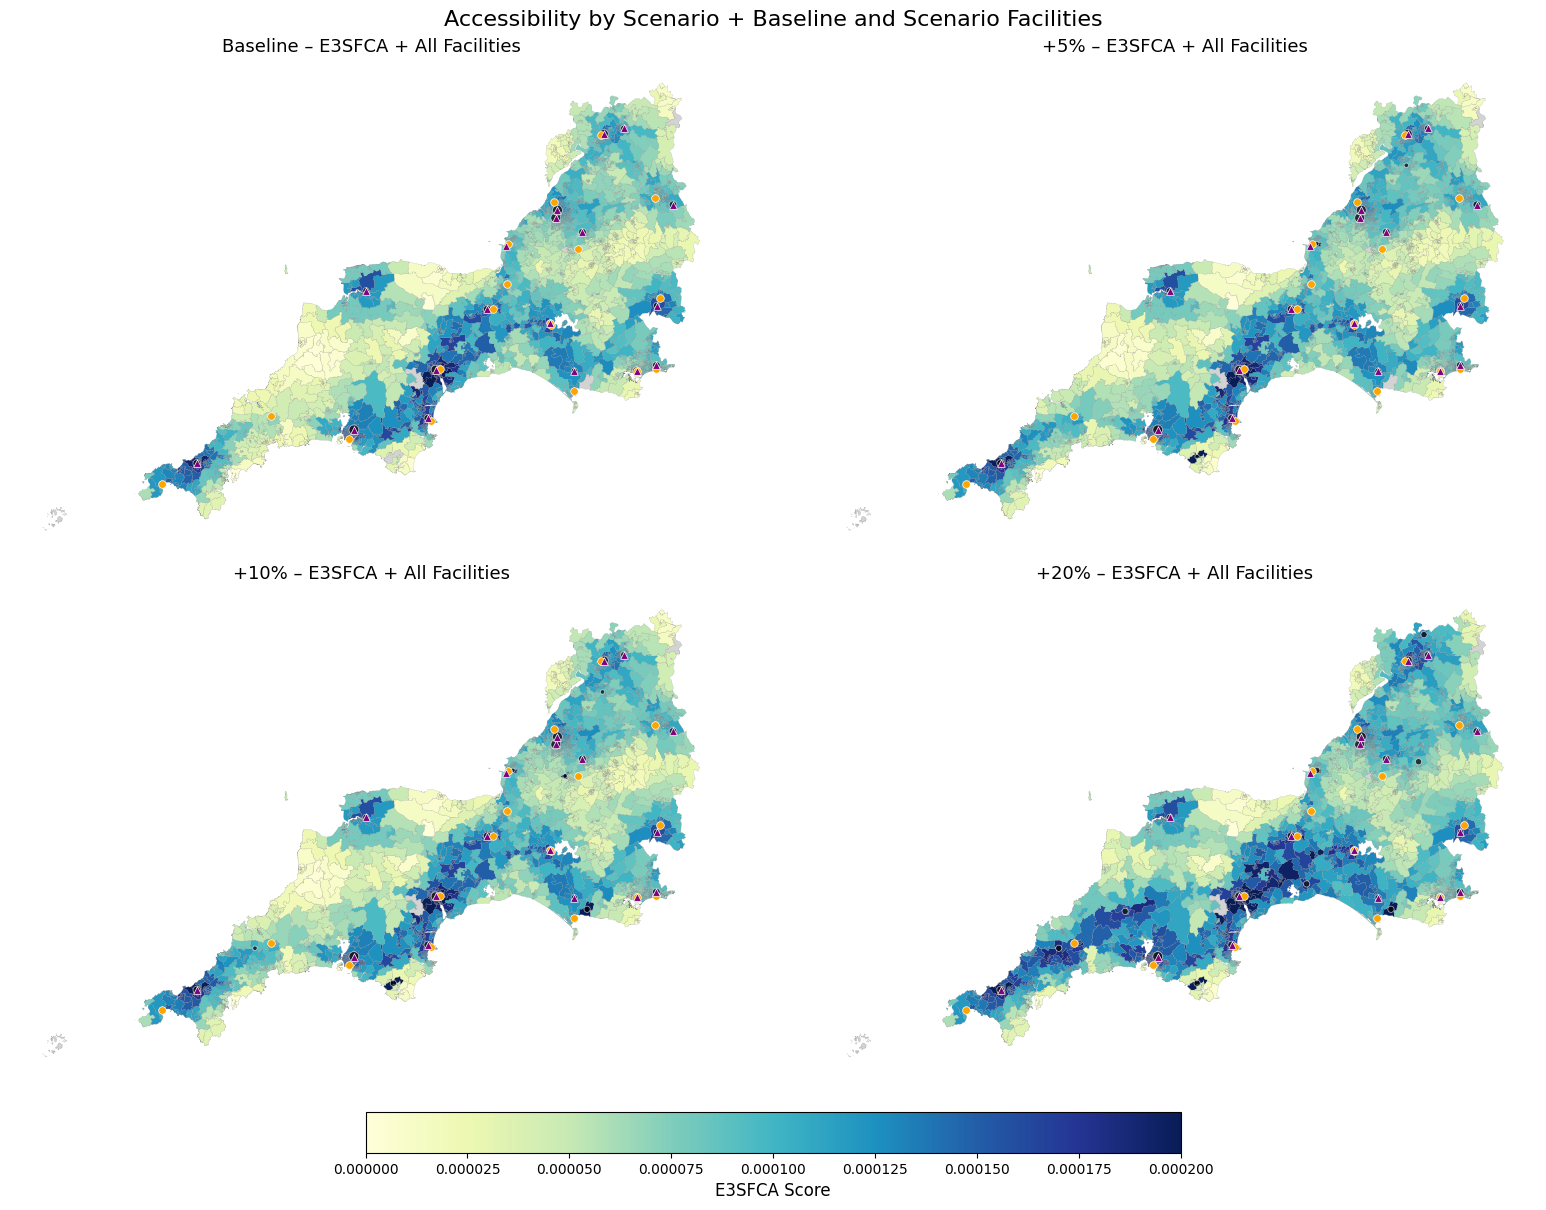

In [11]:
# ----------------------------------------------------------
# Step 8a – E3SFCA Score Maps + CDCs, Acutes, and Scenario Sites
# ----------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Optional: scale scores to make values more readable (uncomment if desired)
# for col in scenarios_plot.values():
#     gdf_lsoa[col] = gdf_lsoa[col] * 1000

# Manual colour scale range for better contrast
vmin = 0.0000
vmax = 0.0002  # Or test 0.0003–0.001 depending on distribution

size_scale = 10

# Filter and prepare CDC and Acute sites once
cdc_df_filtered = pd.read_csv(cdc_path)
acute_df_filtered = pd.read_csv(acute_path)

cdc_df_filtered = cdc_df_filtered[(cdc_df_filtered["CT Scanners"] > 0) & (cdc_df_filtered["lsoa21cd"].notna())].copy()
acute_df_filtered = acute_df_filtered[(acute_df_filtered["CT Scanners"] > 0) & (acute_df_filtered["lsoa21cd"].notna())].copy()

cdc_df_filtered = cdc_df_filtered.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
acute_df_filtered = acute_df_filtered.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")

cdc_gdf = gpd.GeoDataFrame(cdc_df_filtered, geometry="geometry", crs=gdf_lsoa.crs)
acute_gdf = gpd.GeoDataFrame(acute_df_filtered, geometry="geometry", crs=gdf_lsoa.crs)
cdc_gdf["geometry"] = cdc_gdf["geometry"].centroid
acute_gdf["geometry"] = acute_gdf["geometry"].centroid

# Plot each scenario
for ax, (label, score_col) in zip(axes.flat, scenarios_plot.items()):
    gdf_lsoa.plot(
        column=score_col,
        cmap="YlGnBu",
        linewidth=0.1,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"}
    )

    # Overlay scenario sites
    site_df = scenario_site_data[label].copy()
    site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
    site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
    site_gdf["geometry"] = site_gdf["geometry"].centroid

    site_gdf.plot(
        ax=ax,
        color="black",
        markersize=site_gdf["scanner_count"] * size_scale,
        label="Scenario Site",
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5
    )

    # Overlay CDCs
    cdc_gdf.plot(
        ax=ax,
        color="orange",
        markersize=30,
        label="CDC",
        marker="o",
        edgecolor="white",
        linewidth=0.5
    )

    # Overlay Acute hospitals
    acute_gdf.plot(
        ax=ax,
        color="purple",
        markersize=30,
        label="Acute Hospital",
        marker="^",
        edgecolor="white",
        linewidth=0.5
    )

    ax.set_title(f"{label} – E3SFCA + All Facilities", fontsize=13)
    ax.axis("off")

# Shared colourbar
sm = mpl.cm.ScalarMappable(cmap="YlGnBu", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("E3SFCA Score", fontsize=12)

plt.suptitle("Accessibility by Scenario + Baseline and Scenario Facilities", fontsize=16)
plt.show()


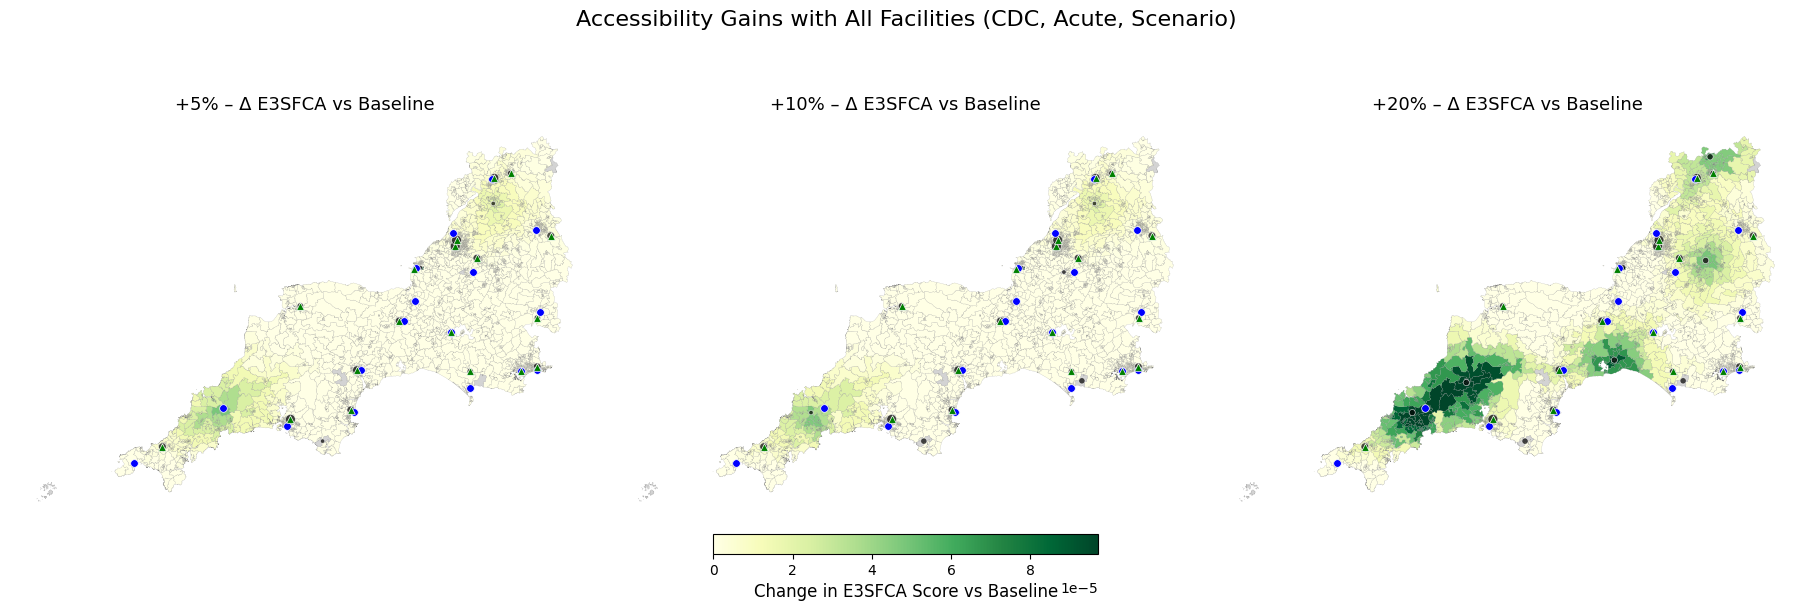

In [16]:
# ----------------------------------------------------------
# Step 8b – Delta Maps (vs Baseline) + CDC, Acute, and Scenario Sites
# ----------------------------------------------------------

# Define delta column mapping for each scenario vs baseline
delta_plot = {
    "+5%": "delta_plus5pct",
    "+10%": "delta_plus10pct",
    "+20%": "delta_plus20pct"
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Manual scale to highlight subtle improvements
vmin_delta = gdf_lsoa[[v for v in delta_plot.values()]].quantile(0.01).min()
vmax_delta = gdf_lsoa[[v for v in delta_plot.values()]].quantile(0.99).max()


for ax, (label, delta_col) in zip(axes.flat, delta_plot.items()):
    gdf_lsoa.plot(
        column=delta_col,
        cmap="YlGn",  # Green = accessibility gain
        linewidth=0.1,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin_delta,
        vmax=vmax_delta,
        missing_kwds={"color": "lightgrey"}
    )

    # Scenario-specific site overlay
    site_df = scenario_site_data[label]
    site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
    site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
    site_gdf["geometry"] = site_gdf["geometry"].centroid

    site_gdf.plot(
        ax=ax,
        color="black",
        markersize=site_gdf["scanner_count"] * size_scale,
        label="Scenario Site",
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5
    )

    # Overlay CDCs
    cdc_gdf.plot(
        ax=ax,
        color="blue",
        markersize=30,
        label="CDC",
        marker="o",
        edgecolor="white",
        linewidth=0.5
    )

    # Overlay Acute hospitals
    acute_gdf.plot(
        ax=ax,
        color="green",
        markersize=30,
        label="Acute Hospital",
        marker="^",
        edgecolor="white",
        linewidth=0.5
    )

    ax.set_title(f"{label} – Δ E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")

# Shared colourbar
sm = mpl.cm.ScalarMappable(cmap="YlGn", norm=mpl.colors.Normalize(vmin=vmin_delta, vmax=vmax_delta))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("Change in E3SFCA Score vs Baseline", fontsize=12)

plt.suptitle("Accessibility Gains with All Facilities (CDC, Acute, Scenario)", fontsize=16)
plt.show()


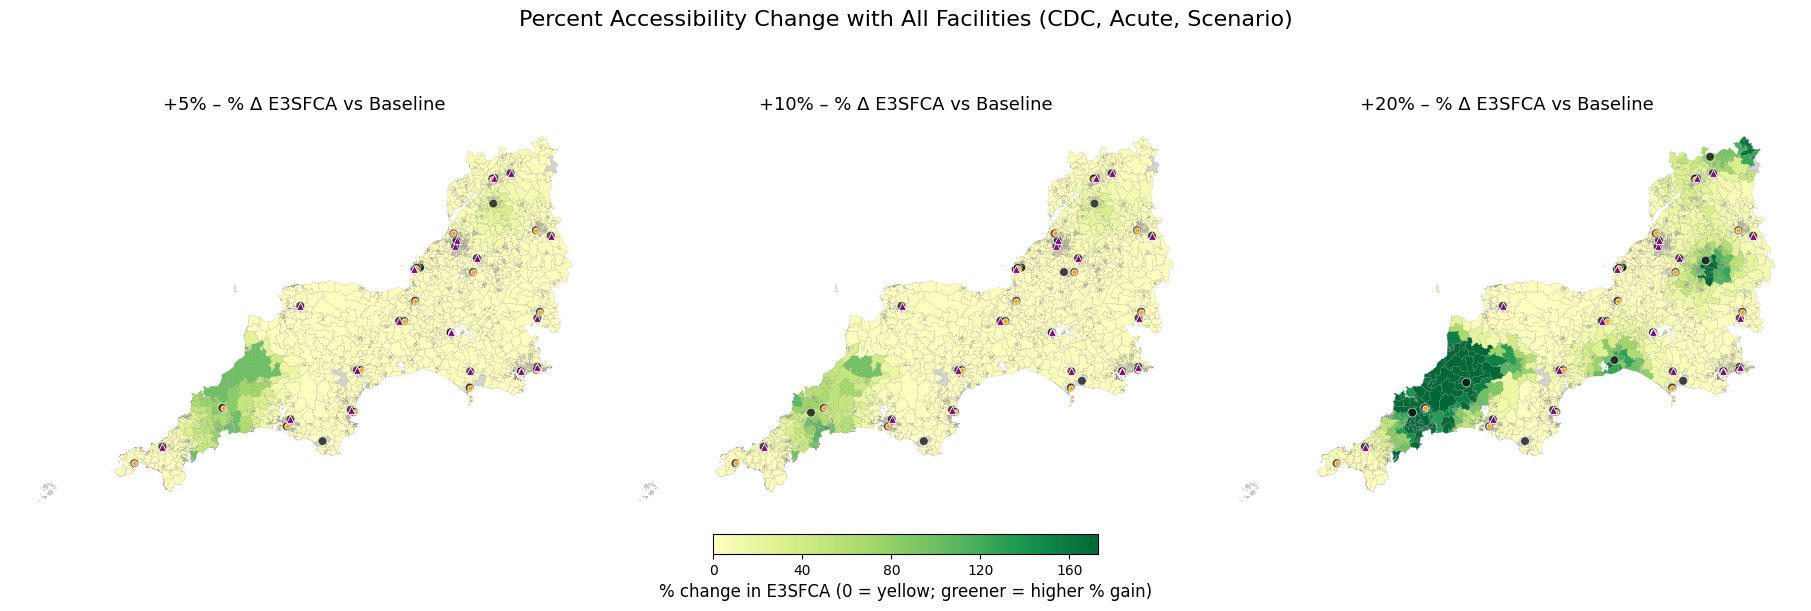

In [21]:
# ----------------------------------------------------------
# Step 8b – % Change Maps (vs Baseline) + CDC, Acute, Scenario Sites
# (icons 50% smaller; colourbar shows only +% with 0 as yellow)
# ----------------------------------------------------------
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# Scenario score columns already merged in Step 7a
scenarios_plot = {"+5%": "score_plus5pct", "+10%": "score_plus10pct", "+20%": "score_plus20pct"}

# Baseline column
baseline_candidates = ["score_baseline","enhanced_3sfca_score_baseline","enhanced_3sfca_score","Fi","fi","E3SFCA"]
baseline_col = next((c for c in baseline_candidates if c in gdf_lsoa.columns), None)
if baseline_col is None:
    raise KeyError("No baseline score column found in gdf_lsoa.")

# % change per LSOA
pct_cols = {}
base = gdf_lsoa[baseline_col].astype(float)
for label, scen_col in scenarios_plot.items():
    scen = gdf_lsoa[scen_col].astype(float)
    pct_col = f"pct_{label.lower().replace('+','plus').replace('%','pct')}"
    gdf_lsoa[pct_col] = np.where(base > 0, (scen - base) / base * 100.0, np.nan)
    pct_cols[label] = pct_col

# Shared symmetric map norm (0 pivot = yellow on RdYlGn)
vals = np.concatenate([gdf_lsoa[c].to_numpy(dtype=float) for c in pct_cols.values()])
vals = vals[np.isfinite(vals)]
low, high = np.percentile(vals, 1), np.percentile(vals, 99)
vabs = float(max(abs(low), abs(high)))
map_norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)

# --- Colourbar that shows only positive side (0..+vabs), with 0 still yellow ---
# Take the upper half of RdYlGn (yellow→green)
_rdylgn = mpl.cm.get_cmap("RdYlGn")
pos_cmap = LinearSegmentedColormap.from_list("RdYlGn_pos", _rdylgn(np.linspace(0.5, 1.0, 256)))
pos_norm = mpl.colors.Normalize(vmin=0.0, vmax=vabs)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Halve icon sizes (scenario + baseline)
size_scale = 40 if "size_scale" not in locals() else size_scale
size_scale *= 0.5  # 50% smaller
clip_min, clip_max = 40, 225       # also halve the floor/cap

for ax, (label, pct_col) in zip(axes.flat, pct_cols.items()):
    # Choropleth (% change)
    gdf_lsoa.plot(
        column=pct_col, cmap="RdYlGn", norm=map_norm,
        linewidth=0.1, edgecolor="grey", legend=False, ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    # Scenario sites (use LSOA centroids for placement)
    site_df = scenario_site_data[label].merge(gdf_lsoa[["lsoa21cd","geometry"]], on="lsoa21cd", how="left")
    site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs).copy()
    site_gdf["geometry"] = site_gdf.geometry.centroid

    ms_sites = (pd.to_numeric(site_gdf.get("scanner_count", 1), errors="coerce")
                .fillna(1).astype(float) * size_scale).clip(clip_min, clip_max)

    site_gdf.plot(ax=ax, color="black", marker="o", markersize=ms_sites,
                  alpha=0.7, edgecolor="white", linewidth=0.6, label="Scenario Site")

    # Baseline facilities (also 50% smaller than before)
    cdc_gdf.plot(  ax=ax, color="orange", marker="o", markersize=15,
                   edgecolor="white", linewidth=0.6, label="CDC")
    acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=30,
                   edgecolor="white", linewidth=0.6, label="Acute Hospital")

    ax.set_title(f"{label} – % Δ E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")

# Positive-only colourbar (0..+vabs), with 0 at yellow
sm_pos = mpl.cm.ScalarMappable(cmap=pos_cmap, norm=pos_norm)
sm_pos._A = []
cbar = fig.colorbar(sm_pos, ax=axes.ravel().tolist(),
                    orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("% change in E3SFCA (0 = yellow; greener = higher % gain)", fontsize=12)

# Ticks (0..+vabs)
from matplotlib.ticker import MaxNLocator
cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.suptitle("Percent Accessibility Change with All Facilities (CDC, Acute, Scenario)", fontsize=16)
plt.show()


In [22]:
# --- Quick summary: how many LSOAs improved/worsened/unchanged (by scenario) ---

import numpy as np
import pandas as pd

# Prefer % change columns if present; else fall back to absolute delta columns
pct_candidates = {"+5%": "pct_plus5pct", "+10%": "pct_plus10pct", "+20%": "pct_plus20pct"}
change_cols = {k: v for k, v in pct_candidates.items() if v in gdf_lsoa.columns}
units = "%"

if not change_cols:
    if "delta_plot" in globals():
        change_cols = delta_plot  # e.g., {" +5%": "delta_plus5pct", ...}
        units = "ΔFi"
    else:
        raise KeyError("No percent-change or delta columns found in gdf_lsoa.")

# Tolerance for treating 'no change' (avoid float noise)
tol = 0.001 if units == "%" else 1e-12  # 0.001% or ~zero in absolute units

rows = []
for label, col in change_cols.items():
    s = pd.to_numeric(gdf_lsoa[col], errors="coerce")
    n = int(s.notna().sum())
    improved = int((s >  tol).sum())
    worsened = int((s < -tol).sum())
    unchanged = int((s.abs() <= tol).sum())

    rows.append({
        "Scenario": label,
        "LSOAs (n)": n,
        "Improved (n)": improved,
        "Improved (%)": (improved / n * 100) if n else np.nan,
        "Worsened (n)": worsened,
        "Worsened (%)": (worsened / n * 100) if n else np.nan,
        "Unchanged (n)": unchanged,
        "Unchanged (%)": (unchanged / n * 100) if n else np.nan,
        "Net (Improved − Worsened)": improved - worsened,
        "Mean change": s.mean(),
        "Median change": s.median(),
        "P10": s.quantile(0.10),
        "P90": s.quantile(0.90),
        "Min": s.min(),
        "Max": s.max(),
        "Units": units
    })

df_change_summary = pd.DataFrame(rows)

# Tidy formatting
pct_cols = ["Improved (%)", "Worsened (%)", "Unchanged (%)"]
df_change_summary[pct_cols] = df_change_summary[pct_cols].round(2)

if units == "%":
    stat_cols = ["Mean change", "Median change", "P10", "P90", "Min", "Max"]
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(2)
else:
    stat_cols = ["Mean change", "Median change", "P10", "P90", "Min", "Max"]
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(6)

display(df_change_summary)


,Scenario,LSOAs (n),Improved (n),Improved (%),Worsened (n),Worsened (%),Unchanged (n),Unchanged (%),Net (Improved − Worsened),Mean change,Median change,P10,P90,Min,Max,Units
0,+5%,3444,1633,47.42,0,0.0,1811,52.58,1633,6.20,0.00,0.0,10.30,0.0,2208.45,%
1,+10%,3444,1581,45.91,0,0.0,1863,54.09,1581,6.13,0.00,0.0,9.96,0.0,2208.45,%
2,+20%,3444,2468,71.66,0,0.0,976,28.34,2468,29.37,7.42,0.0,65.83,0.0,4416.90,%


In [20]:
# ----------------------------------------------------------
# Step 9 – Summary Statistics for E3SFCA Scores and Δ Improvements
# (now includes Baseline in the score summaries)
# ----------------------------------------------------------
import pandas as pd

# Find baseline score column
baseline_candidates = [
    "score_baseline",
    "enhanced_3sfca_score_baseline",
    "enhanced_3sfca_score",
    "Fi", "fi", "E3SFCA",
]
baseline_cols_found = [c for c in baseline_candidates if c in gdf_lsoa.columns]
if not baseline_cols_found:
    raise KeyError(f"No baseline score column found. Have: {list(gdf_lsoa.columns)}")
baseline_col = baseline_cols_found[0]

# --- Absolute score summary (print) ---
print("\n--- E3SFCA Score Summary ---")
print("\nBaseline")
print(gdf_lsoa[baseline_col].describe(percentiles=[0.25, 0.5, 0.75]).round(6))

for label, col in scenarios_plot.items():
    print(f"\n{label}")
    print(gdf_lsoa[col].describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- Δ score summary (print) ---
print("\n--- Δ E3SFCA vs Baseline Summary ---")
for label, delta_col in delta_plot.items():
    print(f"\n{label}")
    print(gdf_lsoa[delta_col].describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- Summary table for absolute scores (now with Baseline row) ---
summary_stats = []

# Baseline row
stats = gdf_lsoa[baseline_col].describe(percentiles=[0.25, 0.5, 0.75])
summary_stats.append({
    "Scenario": "Baseline",
    "Count":    int(stats["count"]),
    "Mean Fi":  stats["mean"],
    "Median Fi":stats["50%"],
    "Min Fi":   stats["min"],
    "Q1":       stats["25%"],
    "Q3":       stats["75%"],
    "Max Fi":   stats["max"],
    "Std Dev":  stats["std"],
})

# Scenario rows
for label, col in scenarios_plot.items():
    stats = gdf_lsoa[col].describe(percentiles=[0.25, 0.5, 0.75])
    summary_stats.append({
        "Scenario": label,
        "Count":    int(stats["count"]),
        "Mean Fi":  stats["mean"],
        "Median Fi":stats["50%"],
        "Min Fi":   stats["min"],
        "Q1":       stats["25%"],
        "Q3":       stats["75%"],
        "Max Fi":   stats["max"],
        "Std Dev":  stats["std"],
    })

df_scores_summary = pd.DataFrame(summary_stats).round(6)
display(df_scores_summary)

# --- Summary table for deltas (unchanged; baseline not applicable) ---
delta_stats = []
for label, col in delta_plot.items():
    stats = gdf_lsoa[col].describe(percentiles=[0.25, 0.5, 0.75])
    delta_stats.append({
        "Scenario":  label,
        "Mean ΔFi":  stats["mean"],
        "Median ΔFi":stats["50%"],
        "Min ΔFi":   stats["min"],
        "Q1":        stats["25%"],
        "Q3":        stats["75%"],
        "Max ΔFi":   stats["max"],
        "Std Dev":   stats["std"],
        "Count":     int(stats["count"]),
    })

df_deltas_summary = pd.DataFrame(delta_stats).round(6)
display(df_deltas_summary)



--- E3SFCA Score Summary ---

Baseline
count    3444.000000
mean        0.000096
std         0.000042
min         0.000001
25%         0.000068
50%         0.000091
75%         0.000121
max         0.000244
Name: score_baseline, dtype: float64

+5%
count    3446.000000
mean        0.000102
std         0.000086
min         0.000001
25%         0.000072
50%         0.000094
75%         0.000124
max         0.003207
Name: score_plus5pct, dtype: float64

+10%
count    3448.000000
mean        0.000106
std         0.000188
min         0.000001
25%         0.000071
50%         0.000094
75%         0.000124
max         0.006799
Name: score_plus10pct, dtype: float64

+20%
count    3447.000000
mean        0.000118
std         0.000195
min         0.000001
25%         0.000080
50%         0.000104
75%         0.000139
max         0.006799
Name: score_plus20pct, dtype: float64

--- Δ E3SFCA vs Baseline Summary ---

+5%
count    3444.000000
mean        0.000004
std         0.000045
min         0.0

,Scenario,Count,Mean Fi,Median Fi,Min Fi,Q1,Q3,Max Fi,Std Dev
0,Baseline,3444,0.000096,0.000091,0.000001,0.000068,0.000121,0.000244,0.000042
1,+5%,3446,0.000102,0.000094,0.000001,0.000072,0.000124,0.003207,0.000086
2,+10%,3448,0.000106,0.000094,0.000001,0.000071,0.000124,0.006799,0.000188
3,+20%,3447,0.000118,0.000104,0.000001,0.000080,0.000139,0.006799,0.000195


,Scenario,Mean ΔFi,Median ΔFi,Min ΔFi,Q1,Q3,Max ΔFi,Std Dev,Count
0,+5%,0.000004,0.000000,0.0,0.0,0.000003,0.001866,0.000045,3444
1,+10%,0.000004,0.000000,0.0,0.0,0.000003,0.001866,0.000045,3444
2,+20%,0.000017,0.000007,0.0,0.0,0.000019,0.003733,0.000092,3444
